## Example 2 - Combining basic vessel class with simpy and graphs

In [1]:
# package(s) related to time, space and id
import datetime
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(0, 10)}
data_node_3 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(10, 10)}
data_node_4 = {"env": [],
               "name": "Node 4",
               "geometry": shapely.geometry.Point(10, 0)}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

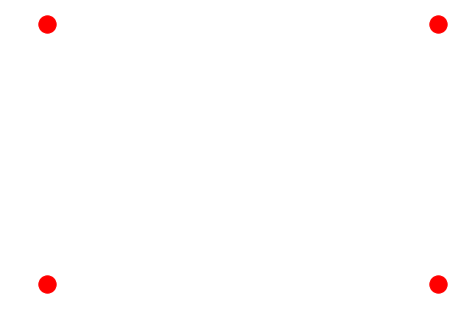

In [3]:
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

nx.draw(FG, positions)
plt.show()

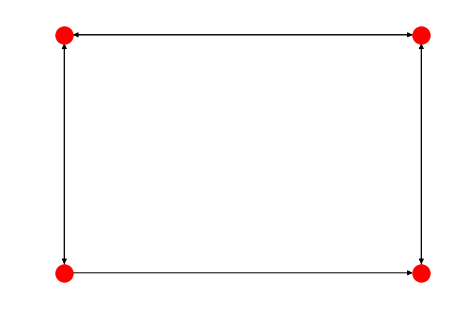

In [4]:
path = [[node_1, node_2], # From node 1 to node 2
        [node_1, node_4], # From node 1 to node 4
        [node_2, node_1], # From node 2 to node 1
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3]] # From node 4 to node 3 - So one-way traffic is from node 1 to node 4

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

nx.draw(FG, positions)
plt.show()

In [5]:
print("From 1 to 4:", nx.shortest_path_length(FG, "Node 1", "Node 4"))
print("From 4 to 1:", nx.shortest_path_length(FG, "Node 4", "Node 1"))

From 1 to 4: 1
From 4 to 1: 3


### Create vessels

In [6]:
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})

env = simpy.Environment()

def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

data_vessel = {"env": env,
               "name": "Transport barge 01",
               "route": FG,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1.6, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Run simulation

In [7]:
def start(env, vessel, origination, destination):
    while True:
        yield from vessel.move(origination, destination)
        
        if vessel.geometry == destination.geometry:
            break

In [8]:
sim_start = env.now

env.process(start(env, vessel, node_1, node_4))
env.run()

print(env.now - sim_start)

695746.8174579598


In [9]:
sim_start = env.now

env.process(start(env, vessel, node_4, node_1))
env.run()

print(env.now - sim_start)

2067538.263148594
